# Data Preprocessing

In [7]:
import pandas as pd

# Read data
title_basics = pd.read_csv('./imdb data/title.basics.tsv', sep='\t', na_values='\\N')
title_ratings = pd.read_csv('./imdb data/title.ratings.tsv', sep='\t', na_values='\\N')
name_basics = pd.read_csv('./imdb data/name.basics.tsv', sep='\t', na_values='\\N')

# Filter movie data and merge with ratings
movies = title_basics[title_basics['titleType'] == 'movie']

# Filter movie rating number
title_ratings = title_ratings[title_ratings['numVotes']> 100000]

movies = movies.merge(title_ratings, on='tconst', how='inner')

# Filter director information
directors = name_basics[name_basics['primaryProfession'].str.contains('director', na=False)]
directors['knownForTitles'] = directors['knownForTitles'].fillna('').str.split(',')

# Merge directors with their known titles to the movie data
directors_movies = directors.explode('knownForTitles').merge(
    movies, left_on='knownForTitles', right_on='tconst', how='inner'
)

# Extract director, rating, and associated genre information
director_genres = directors_movies[['primaryName', 'averageRating', 'genres']].dropna()
director_genres['genres'] = director_genres['genres'].str.split(',')

# Calculate the number of unique genres and average rating per director
director_genres_exploded = director_genres.explode('genres')
genre_counts = director_genres_exploded.groupby('primaryName')['genres'].nunique()
average_ratings = director_genres_exploded.groupby('primaryName')['averageRating'].mean()

# Combine genre count and average rating data
director_analysis = pd.DataFrame({
    'num_genres': genre_counts,
    'avg_rating': average_ratings
})


/var/folders/bj/ksyk_mkx4m5fdtj17h6lblzh0000gn/T/ipykernel_78839/2976573663.py:4: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  title_basics = pd.read_csv('./imdb data/title.basics.tsv', sep='\t', na_values='\\N')
/var/folders/bj/ksyk_mkx4m5fdtj17h6lblzh0000gn/T/ipykernel_78839/2976573663.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  directors['knownForTitles'] = directors['knownForTitles'].fillna('').str.split(',')


# Average Rating for Two Types of Directors

In [8]:
# Check if directors focused on one or two genres have higher average ratings
high_rated_directors = director_analysis[director_analysis['num_genres'] <= 2]
low_rated_directors = director_analysis[director_analysis['num_genres'] > 2]

# Print the average ratings of both groups
print("Average rating of directors focusing on one or two genres:", high_rated_directors['avg_rating'].mean())
print("Average rating of directors working in multiple genres:", low_rated_directors['avg_rating'].mean())

Average rating of directors focusing on one or two genres: 7.164207532582284
Average rating of directors working in multiple genres: 6.9702403898396765


The data indicates that directors who focus on one or two movie genres tend to achieve higher average ratings (7.16) compared to those who direct across multiple genres (6.97). This suggests that specialization in fewer genres may contribute to higher-quality work, potentially due to deeper expertise and focused storytelling skills within those specific genres. Directors who spread their efforts across multiple genres might face challenges in maintaining consistent quality, as adapting to different genre conventions requires versatile but possibly diluted proficiency. This analysis highlights a trend where genre specialization can be associated with a modest but meaningful increase in the average rating of films directed.

# Distribution of Directors

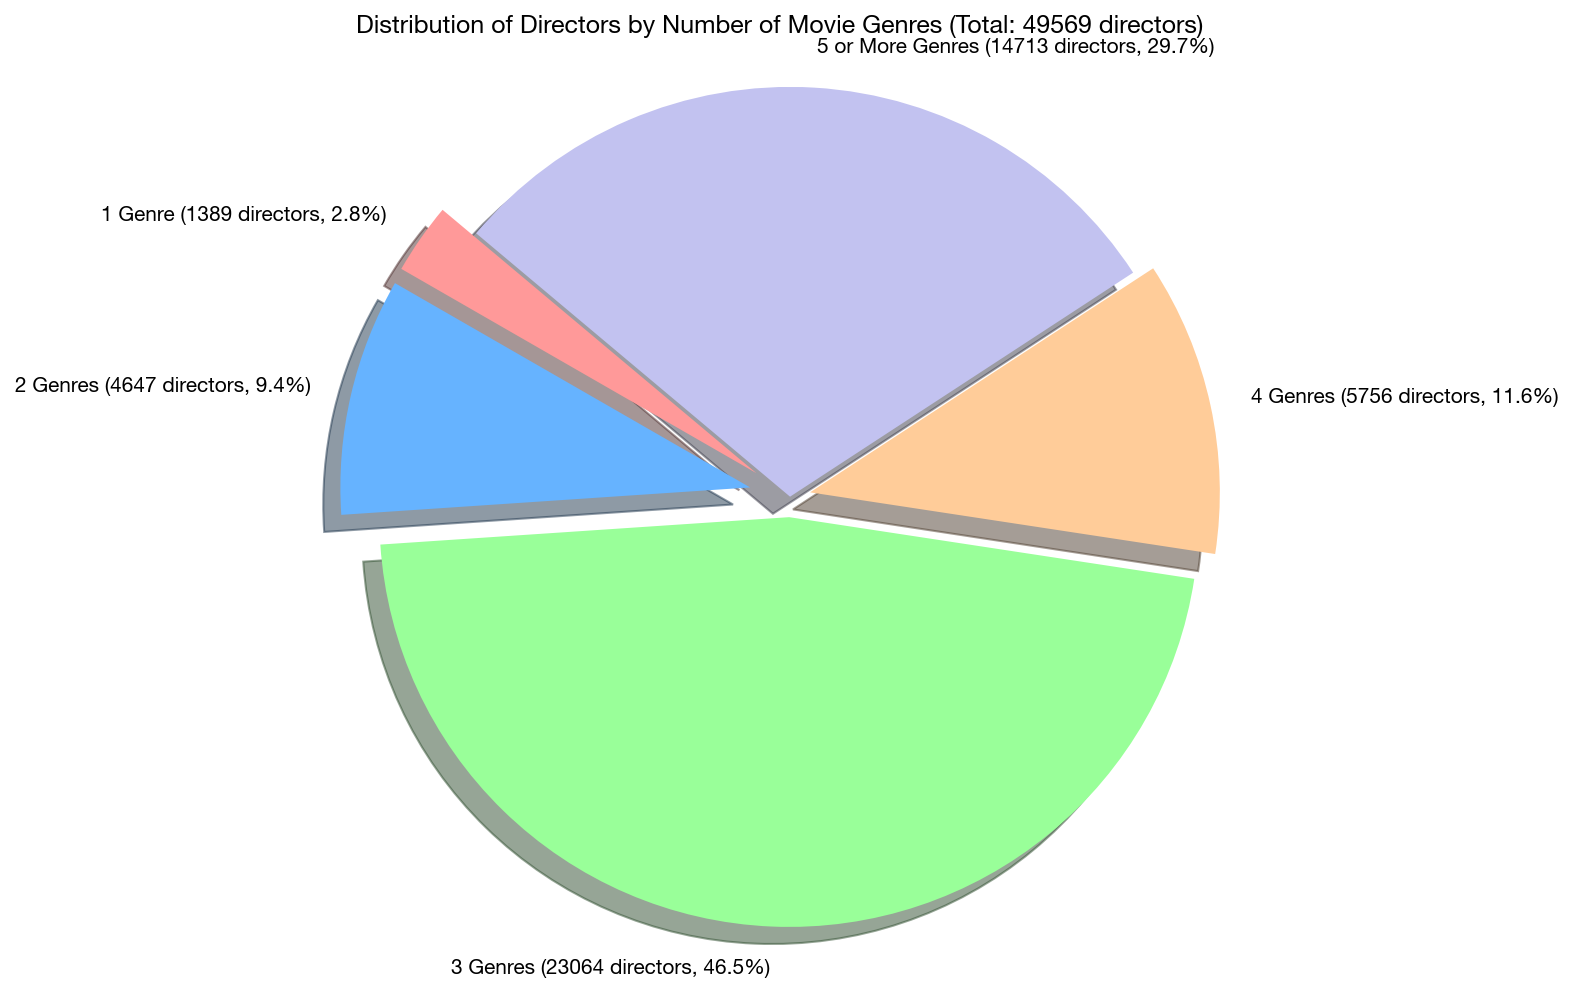

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams

# Set font to Apple system font and increase DPI for higher resolution
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Helvetica Neue', 'Arial']
plt.rcParams['figure.dpi'] = 150

# Classify directors based on the number of unique genres they work in
director_count_by_genre = director_analysis['num_genres'].apply(
    lambda x: '1 Genre' if x == 1 else (
        '2 Genres' if x == 2 else (
            '3 Genres' if x == 3 else (
                '4 Genres' if x == 4 else '5 or More Genres'
            )
        )
    )
).value_counts()

# Reorder categories according to the desired sequence
desired_order = ['1 Genre', '2 Genres', '3 Genres', '4 Genres', '5 or More Genres']
director_count_by_genre = director_count_by_genre.reindex(desired_order)

# Calculate the percentage for each category
director_count_by_genre_percentage = director_count_by_genre / director_count_by_genre.sum() * 100

# Create labels to show the count and percentage for each category
total_directors = director_count_by_genre.sum()
labels = [f"{cat} ({count} directors, {pct:.1f}%)" for cat, count, pct in zip(
    director_count_by_genre.index,
    director_count_by_genre,
    director_count_by_genre_percentage
)]

# Plotting the pie chart with improved clarity and Apple font
plt.figure(figsize=(12, 8))
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#c2c2f0']
explode = (0.1, 0.1, 0.05, 0.05, 0)  # Emphasize the first four sections

plt.pie(
    director_count_by_genre_percentage, 
    labels=labels,
    autopct='',  # Turn off default autopct
    startangle=140,
    colors=colors,
    explode=explode,
    shadow=True
)
plt.title(f'Distribution of Directors by Number of Movie Genres (Total: {total_directors} directors)')
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular
plt.show()


This pie chart represents the distribution of directors by the number of movie genres they have worked in, focusing on those with more than two films. Out of 49,569 directors analyzed, nearly half (46.5%) have worked in three genres, making it the largest group at 23,064 directors. Directors who have worked in five or more genres account for 29.7% (14,713 directors), indicating a significant portion with broad genre experience. Directors specializing in four genres make up 11.6% (5,756 directors), while those with experience in two or fewer genres form a smaller proportion: 9.4% (4,647 directors) for two genres and 2.8% (1,389 directors) for one genre. This distribution suggests that many directors tend to focus on a limited range of genres, though a notable number work across a diverse set of genres.

# Average Rating for All Types of Directors

In [10]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

# Group directors with 10 or more genres into one category
director_analysis['num_genres'] = director_analysis['num_genres'].apply(lambda x: '10+' if x >= 10 else str(x))

# Calculate the average rating for directors based on the number of genres they have worked in
average_rating_by_genre_count = director_analysis.groupby('num_genres')['avg_rating'].mean()

# Sort the index numerically where possible, treating "10+" as the last item
average_rating_by_genre_count = average_rating_by_genre_count.sort_index(key=lambda x: pd.to_numeric(x, errors='coerce').fillna(float('inf')))

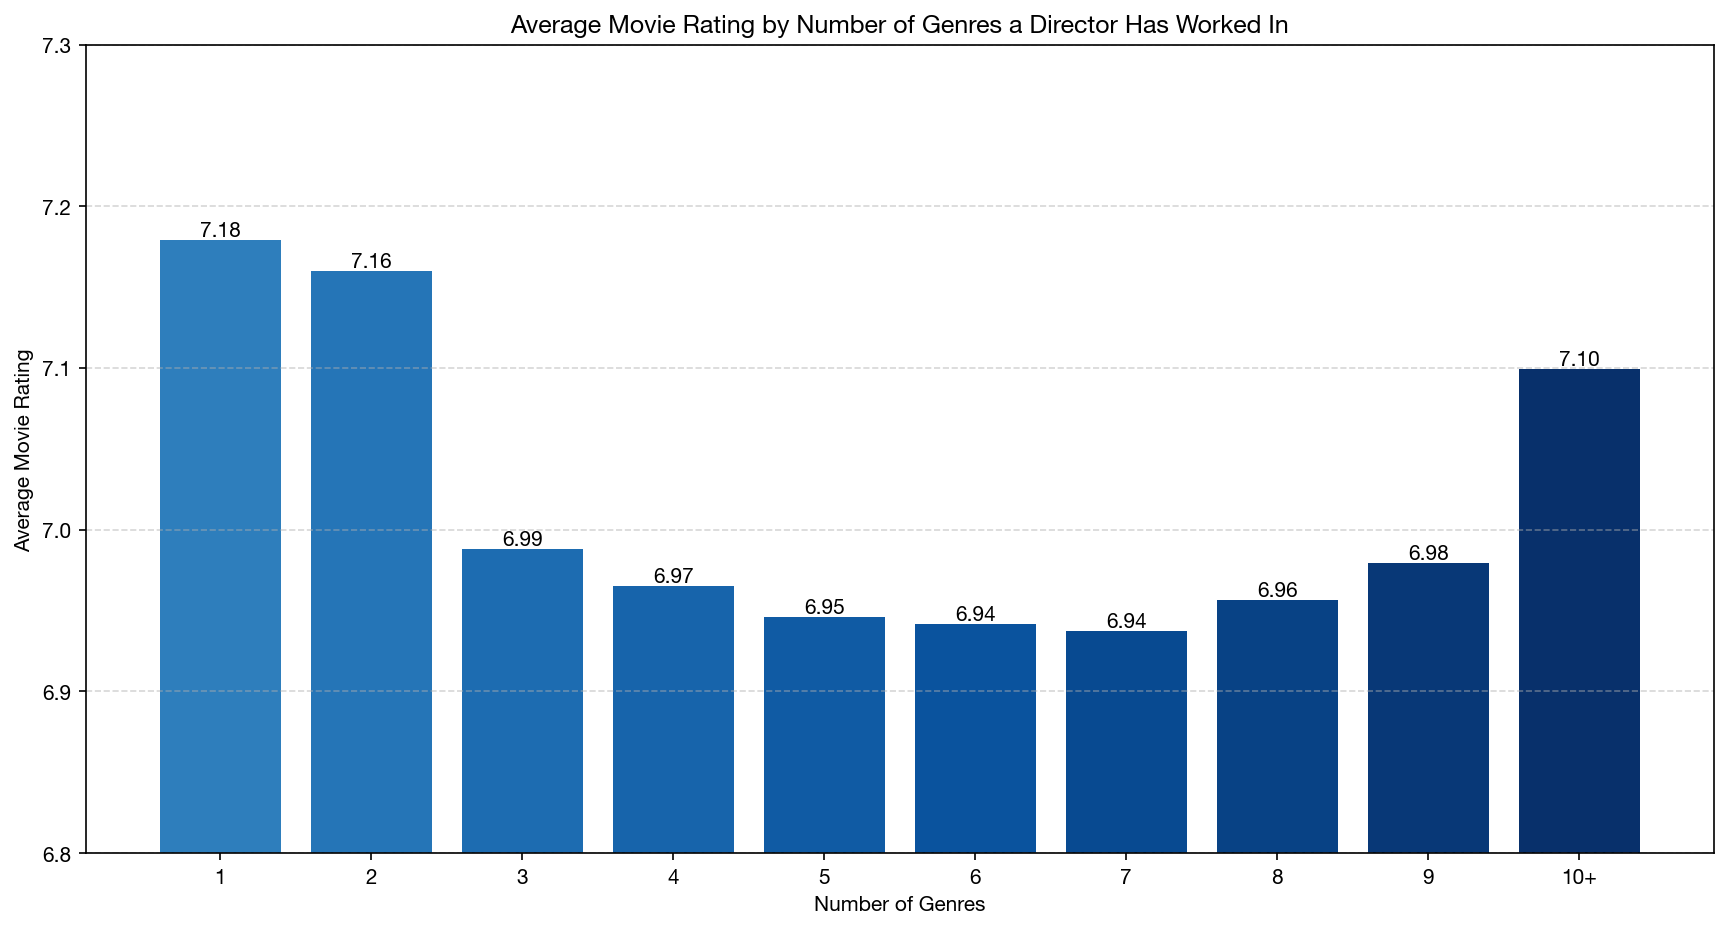

In [11]:
import numpy as np

# Generate a gradient color range from dark blue to light blue
num_bars = len(average_rating_by_genre_count)
colors = plt.cm.Blues(np.linspace(0.7, 1, num_bars))

# Plotting the bar chart with gradient colors
plt.figure(figsize=(14, 7))
bars = plt.bar(average_rating_by_genre_count.index, average_rating_by_genre_count.values, color=colors)

# Adding average ratings on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:.2f}', va='bottom', ha='center')

# Customizing the chart
plt.title('Average Movie Rating by Number of Genres a Director Has Worked In')
plt.xlabel('Number of Genres')
plt.ylabel('Average Movie Rating')
plt.xticks(average_rating_by_genre_count.index)  # Ensure all genre counts are shown on the x-axis
plt.ylim(6.8, 7.3)  # Set y-axis range from 6 to 7
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Apply Apple system font for better aesthetics
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Helvetica Neue', 'Arial']

plt.show()

This bar chart illustrates the average movie ratings for directors based on the number of genres they have worked in. Directors who specialize in just one genre have the highest average rating of 7.18, indicating that deep expertise in a single genre can contribute to higher-quality films. Similarly, directors who focus on two genres maintain a high average rating of 7.16. However, as the number of genres increases from three to seven, there is a noticeable decline in average ratings, with values hovering between 6.94 and 6.99. Interestingly, directors who have experience in 10 or more genres show a rebound in their average ratings, reaching 7.10. This suggests that while moderate diversification may challenge a director's ability to maintain consistent quality, extensive experience across many genres may develop a versatility that contributes to higher ratings. Overall, specialization or broad versatility appears to have a positive impact on average movie ratings.